In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import ImageFilter


In [32]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list

def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img):

    v = np.median(img)
    sigma = 0.33

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(max(0, (1.0 + sigma) * v))

    img = cv2.Canny(img, lower, upper)
    return img


In [ ]:
test = 'train'



image_list = load_images("./train/Hairline Fracture")
#print(image_list[0])


[[19 19 19 ... 32 32 32]
 [19 19 19 ... 32 32 32]
 [19 19 19 ... 32 32 32]
 ...
 [22 22 22 ... 36 36 36]
 [22 22 22 ... 36 36 36]
 [22 22 22 ... 36 36 36]]


<function matplotlib.pyplot.show(close=None, block=None)>

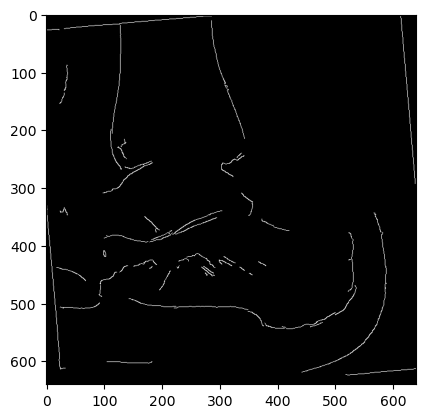

In [38]:

for i, img in enumerate(image_list):
    img = find_edges(img)
    image_list[i] = img


plt.imshow(image_list[0], cmap='gray')
#plt.imshow(img_arr[30])
plt.show